<a href="https://colab.research.google.com/github/ABJ66/test_tsa/blob/main/Prepare_and_Analyze_Time_Series_Milestone_3_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare and Analyze Time Series - Milestone 3

This Jupyter notebook serves as a guided workflow to Milestone 3 of the liveProject on End-to-end Time Series Forecasting with Deep Learning.

You can upload this notebook to Colab and work from there. Alternatively, you can also work on this notebook in your local environment.

Great job on completing previous Milestones and reaching the final MileStone! We have processed, cleaned and analyzed the data so we can now proceed with our modeling as shown in the diagram below.

![Milestone 3](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/project1_milestone3.png)

In this final Milestone 3, we shall complete 3 tasks:
1. Build baseline model using Naive and sNaive methods
2. Understand the various metrics for evaluation of time series model and decide on our metrics
3. Set up model using Facebook Prophet for comparison

Without further ado, let's begin!

## Importing Necessary Libraries and Functions

Let us first import the necessary libraries and load the data that we will be working with throughout this Milestone. 

The data (data/sales_cleaned.csv) that we are using is an output from previous Milestone. 

Again, recall that in this liveProject, you are a data scientist at a large retailer and your challenge is to forecast the sales of the respective stores by each category for the next 28 days.

In [2]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
if RunningInCOLAB:
  !pip install prophet
from prophet import Prophet
import itertools

%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

## Building our Baseline Model

In order to know how well our models are performing, we need a baseline model for reference. The baseline model will use a very quick and simple method (in our case, Naive or sNaive method) and our models must have better performance than the baseline to be useful.

The Naive method uses the last known observation of the time series as forecasts for the next 28 days.

The Seasonal Naive (sNaive) method is similar to the Naive method, but this time the forecasts of the model are equal to the last known observation of the same seasonal period. In our case, we will set the period as 7 days based on our analysis in previous Milestone.

<ins>Instructions</ins>:<br>
- Let's read in our sales_cleaned.csv data and paste our train-test split function from previous Milestone.

<ins>Hints</ins> (click when needed):<br>
- [Follow the example code here to upload files to Colab from your local file system](https://colab.research.google.com/notebooks/io.ipynb)
- [Use Pandas `read_csv` function to load CSV data](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [3]:
# upload file from Colab
sales_processed_df = pd.read_csv('/content/sales_cleaned_aj.csv', parse_dates=['date'])

In [4]:
sales_processed_df.head()

,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
1,2011-01-30,TX_1,FOODS,3844.97
2,2011-01-31,TX_1,FOODS,2888.03
3,2011-02-01,TX_1,FOODS,3631.28
4,2011-02-02,TX_1,FOODS,3072.18


In [ ]:
# read in our processed data
# by using parse_dates in parameter of read_csv, we can convert date column to datetime format without additional step


In [5]:
# copy and paste the train-test split function from previous Milestone
def get_cv_split(df, split_num, prediction_length=28, validation=True):
    """
    Implement train-test split given a cv split number and return training, val and test data
    """
    if 'series_id' not in df.columns:
        df['series_id'] = df['store_id'] + '_' + df['cat_id']
    series_list = df['series_id'].unique()

    test_list = []
    validation_list = []
    training_list = []

    for series in series_list:
        df_series = df.loc[df.series_id==series]
        max_date = df_series.date.max()
        min_date = df_series.date.min()
        test_lower_date = max_date - pd.Timedelta(f"{prediction_length*((split_num+1)*2-1)} days")
        test_upper_date = max_date - pd.Timedelta(f"{prediction_length*(split_num*2)} days")
        val_lower_date = max_date - pd.Timedelta(f"{prediction_length*(split_num+1)*2} days")
        if min(test_lower_date, test_upper_date) < min_date:
            raise Exception("Insufficient data for splitting")

        df_series_test = df_series.loc[(df_series.date > test_lower_date) & (df_series.date <= test_upper_date)]
        if validation:
            df_series_val = df_series.loc[(df_series.date > val_lower_date) & (df_series.date <= test_lower_date)]
            df_series_train = df_series.loc[df_series.date <= val_lower_date]
        else:
            df_series_val = pd.DataFrame()
            df_series_train = df_series.loc[df_series.date <= test_lower_date]
        test_list.append(df_series_test)
        validation_list.append(df_series_val)
        training_list.append(df_series_train)

    test_df = pd.concat(test_list)
    validation_df = pd.concat(validation_list)
    training_df = pd.concat(training_list)
    return training_df, validation_df, test_df

<ins>Instructions</ins>:<br>
- Now let's start off with implementing the Naive method. Develop a function that will take in the training and test data and return a dataframe containing the test data and corresponding predictions.

<ins>Hints</ins> (click when needed):<br>
- [Refer to the section on "Start with a Naive Approach" to understand more about the Naive method](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/)


In [8]:
training_df.head()

,date,store_id,cat_id,sales,series_id
0,2011-01-29,TX_1,FOODS,3950.35,TX_1_FOODS
1,2011-01-30,TX_1,FOODS,3844.97,TX_1_FOODS
2,2011-01-31,TX_1,FOODS,2888.03,TX_1_FOODS
3,2011-02-01,TX_1,FOODS,3631.28,TX_1_FOODS
4,2011-02-02,TX_1,FOODS,3072.18,TX_1_FOODS


In [45]:
# Implement the Naive method function
def naive_predictions(training_df, test_df):
    """
    Implement the Naive method and return dataframe with test data and corresponding predictions
    """
    if 'series_id' not in training_df.columns:
        training_df['series_id'] = training_df['store_id'] + '_' + training_df['cat_id']
    series_list = training_df['series_id'].unique()

    naive_test_list = []

    for series in series_list:
      training_df_series = training_df.loc[training_df.series_id==series]
      naive_pred_df = training_df_series.loc[training_df_series.date == training_df_series.date.max(), ['store_id','cat_id', 'sales']]
      naive_pred_df.rename(columns={'sales':'naive_pred'}, inplace=True)
      naive_test_df = test_df.merge(naive_pred_df, on=['store_id','cat_id'], how='left').reset_index(drop = True)
      naive_test_list.append(naive_test_df)
    
    naive_test_df = pd.concat(naive_test_list)
    return naive_test_df.reset_index(drop = True)

In [23]:
# Naive method for first cv split
training_df, validation_df, test_df = get_cv_split(df=sales_processed_df, split_num=1, prediction_length=28, validation=True)

In [46]:
naive_test_df = naive_predictions(training_df = training_df, test_df = test_df)
#test_df.loc[test_df['series_id'] == 'TX_1_FOODS',:]

In [21]:
#training_df.loc[training_df['series_id'] == 'TX_1_FOODS', 'date'].max() # ('2016-01-31 00:00:00')
training_df.loc[(training_df['series_id'] == 'TX_1_FOODS') & (training_df['date'] == '2016-01-31 00:00:00'),:]

,date,store_id,cat_id,sales,series_id
1828,2016-01-31,TX_1,FOODS,6202.96,TX_1_FOODS


In [39]:
#training_df.date.max() # Timestamp('2016-01-31 00:00:00')
naive_test_df.groupby(['store_id', 'cat_id'])['sales'].count()

store_id  cat_id   
CA_1      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
CA_2      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
CA_3      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
CA_4      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
TX_1      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
TX_2      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
TX_3      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
WI_1      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
WI_2      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
WI_3      FOODS        840
          HOBBIES      840
          HOUSEHOLD    840
Name: sales, dtype: int64

Let's plot our Naive predictions against real data for visualization.

<ins>Instructions</ins>:<br>
- For a given time series, plot the Naive predictions against actual sales

<ins>Hints</ins> (click when needed):<br>
- [Use Seaborn `lineplot` to plot line plots](https://seaborn.pydata.org/generated/seaborn.lineplot.html)

In [59]:
naive_test_df.columns

Index(['date', 'store_id', 'cat_id', 'sales', 'series_id', 'naive_pred'], dtype='object')

In [17]:
import seaborn as sns

In [68]:
# function for plotting predictions against actual sales given series_id
def plot_pred(prediction_test_df, series_id, yhat):
    """
    Plot the predictions against actual sales for a specified time series
    """
    print(yhat)
    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(data=prediction_test_df.loc[prediction_test_df['series_id'] ==  series_id,:], x='date', y='sales')
    sns.lineplot(data=prediction_test_df.loc[prediction_test_df['series_id'] ==  series_id,:], x='date', y=yhat)

In [85]:
naive_test_df.tail(10)

,date,store_id,cat_id,sales,series_id,naive_pred
25190,2016-03-18,WI_3,HOUSEHOLD,2660.75,WI_3_HOUSEHOLD,3923.66
25191,2016-03-19,WI_3,HOUSEHOLD,3484.43,WI_3_HOUSEHOLD,3923.66
25192,2016-03-20,WI_3,HOUSEHOLD,3333.94,WI_3_HOUSEHOLD,3923.66
25193,2016-03-21,WI_3,HOUSEHOLD,2648.48,WI_3_HOUSEHOLD,3923.66
25194,2016-03-22,WI_3,HOUSEHOLD,2245.26,WI_3_HOUSEHOLD,3923.66
25195,2016-03-23,WI_3,HOUSEHOLD,1808.48,WI_3_HOUSEHOLD,3923.66
25196,2016-03-24,WI_3,HOUSEHOLD,1854.75,WI_3_HOUSEHOLD,3923.66
25197,2016-03-25,WI_3,HOUSEHOLD,3273.26,WI_3_HOUSEHOLD,3923.66
25198,2016-03-26,WI_3,HOUSEHOLD,3684.77,WI_3_HOUSEHOLD,3923.66
25199,2016-03-27,WI_3,HOUSEHOLD,3278.37,WI_3_HOUSEHOLD,3923.66


naive_pred


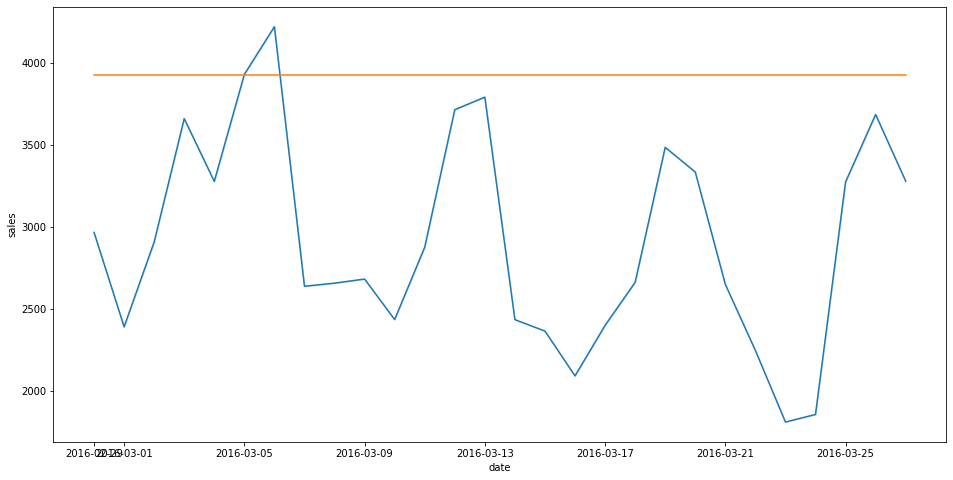

In [69]:
# Plot the predictions against actual sales for a specified time series
plot_pred(naive_test_df, 'WI_3_HOUSEHOLD', 'naive_pred')

From our plot, we can see that the Naive predictions are uninteresting; just a horizontal straight line of constant value. Well, it's naive after all.

Now, let's implement the sNaive method. Remember, the seasonal period for our case is 7 days.

<ins>Instructions</ins>:<br>
- Implement the sNaive method using the last 7 known observations of each time series. Develop a function that will take in the training and test data and return a dataframe containing the test data and corresponding predictions.

<ins>Hints</ins> (click when needed):<br>
- [sNaive notes (read on what to do when prediction_length > season_length)](https://ts.gluon.ai/api/gluonts/gluonts.model.seasonal_naive.html)
> """

> If prediction_length > season_length, then the season is repeated multiple times

> """

In [66]:
# Implement the sNaive method in a function
def snaive_predictions(training_df, test_df):
    """
    Implement the sNaive method and return dataframe with test data and corresponding predictions
    """
    if 'series_id' not in training_df.columns:
      training_df['series_id'] = training_df['store_id'] + '_' + training_df['cat_id']
    series_list = training_df['series_id'].unique()

    snaive_test_list = []

    for series in series_list:
      training_df_series = training_df.loc[training_df.series_id==series]
      training_df_series['dayofweek'] = training_df_series['date'].dt.weekday
      training_df_series.sort_values(by='date', ascending=False, inplace=True)
      snaive_pred_df = training_df_series[:7][['dayofweek', 'sales']]
      snaive_pred_df.rename(columns={'sales':'snaive_pred'}, inplace=True)
      test_df['dayofweek'] = test_df['date'].dt.weekday
      snaive_test_df = test_df.merge(snaive_pred_df, on=['dayofweek'], how='left')
      snaive_test_list.append(snaive_test_df)

    snaive_test_df = pd.concat(snaive_test_list)

    return snaive_test_df.reset_index(drop = True)

In [67]:
# sNaive predictions for first cv split
#training_df, validation_df, test_df = get_cv_split(df=sales_processed_df, split_num=1, prediction_length=28, validation=True)
snaive_test_df = snaive_predictions(training_df = training_df, test_df = test_df)

In [39]:
training_df.head(10)

,date,store_id,cat_id,sales,series_id,dayofweek
54774,2016-01-31,WI_3,HOUSEHOLD,3923.66,WI_3_HOUSEHOLD,6
42308,2016-01-31,WI_1,HOBBIES,1955.78,WI_1_HOBBIES,6
43614,2016-01-31,WI_1,HOUSEHOLD,3695.58,WI_1_HOUSEHOLD,6
1828,2016-01-31,TX_1,FOODS,6202.96,TX_1_FOODS,6
21238,2016-01-31,CA_1,HOBBIES,2976.65,CA_1_HOBBIES,6
35186,2016-01-31,CA_4,FOODS,5672.60,CA_4_FOODS,6
45069,2016-01-31,WI_2,FOODS,8759.93,WI_2_FOODS,6
19297,2016-01-31,CA_1,FOODS,10637.42,CA_1_FOODS,6
17356,2016-01-31,TX_3,HOUSEHOLD,4416.55,TX_3_HOUSEHOLD,6
47010,2016-01-31,WI_2,HOBBIES,1206.71,WI_2_HOBBIES,6


In [40]:
training_df[:7]

,date,store_id,cat_id,sales,series_id,dayofweek
54774,2016-01-31,WI_3,HOUSEHOLD,3923.66,WI_3_HOUSEHOLD,6
42308,2016-01-31,WI_1,HOBBIES,1955.78,WI_1_HOBBIES,6
43614,2016-01-31,WI_1,HOUSEHOLD,3695.58,WI_1_HOUSEHOLD,6
1828,2016-01-31,TX_1,FOODS,6202.96,TX_1_FOODS,6
21238,2016-01-31,CA_1,HOBBIES,2976.65,CA_1_HOBBIES,6
35186,2016-01-31,CA_4,FOODS,5672.60,CA_4_FOODS,6
45069,2016-01-31,WI_2,FOODS,8759.93,WI_2_FOODS,6


Similarly, let's plot our sNaive predictions against the actual sales for a random time series.

<ins>Instructions</ins>:<br>
- Plot the sNaive predictions against the actual sales for a time series

<ins>Hints</ins> (click when needed):<br>
- [Use Seaborn `lineplot` to plot line plots](https://seaborn.pydata.org/generated/seaborn.lineplot.html)

snaive_pred


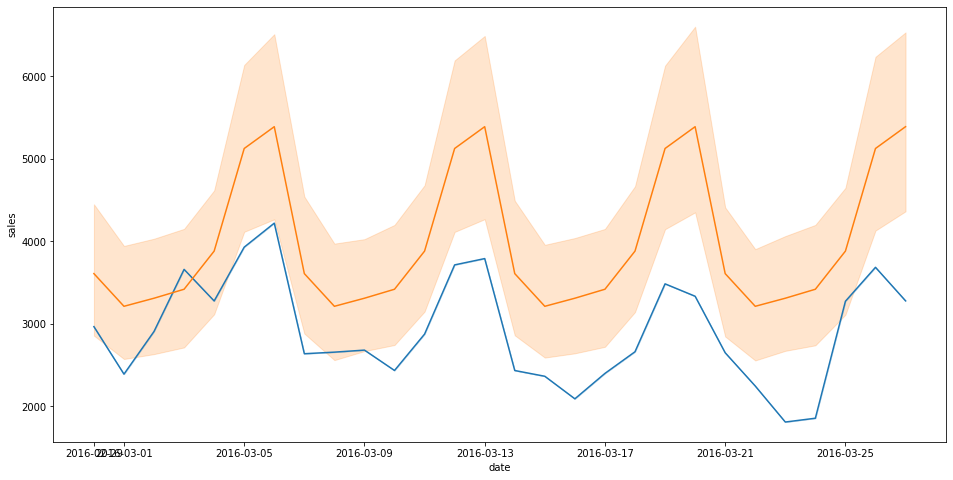

In [70]:
# plot sNaive predictions against actual sales for a time series
plot_pred(snaive_test_df, 'WI_3_HOUSEHOLD', 'snaive_pred')

This time round, the sNaive predictions seem much more realistic and is somehow able to follow the oscillations of the actual sales.

Intuitively, we know that the sNaive method will be a better baseline than the Naive method. But rather than seeing random plots comparing the predictions against actual sales, is there a score that we can use to summarise the model performance?

This is what we shall set out to do in the next section below.

## Choosing our Metrics

In time series, there are various metrics that we can use to evaluate our models.

Based on Prof Rob Hyndman in this [paper](https://robjhyndman.com/papers/foresight.pdf), there are four types of metrics for time series forecasting. In our case, we shall compute Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) for each time series.

In addition, because we have multiple time series, we need to somehow weigh the score for each time series and combine them into a single overall score. In our case, we shall weigh the time series based on the cumulative actual dollar sales, which is computed using the last 28 observations of the training data. This weightage method follows the [M5 competition in Kaggle](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation). 

<ins>Instructions</ins>:<br>
- Implement a function that given a time series, computes the MAE
- Implement a function that given a training and test data, computes the weighted MAE
- Implement code to calculate the cross-validated weighted MAE for the Naive and sNaive models respectively. Use 3 splits.

<ins>Hints</ins> (click when needed):<br>
- [Refer to this link for the MAE formula](https://en.wikipedia.org/wiki/Mean_absolute_error)
- [Read page 8 of this document to understand how weighting is performed](https://mofc.unic.ac.cy/wp-content/uploads/2020/03/M5-Competitors-Guide-Final-10-March-2020.docx)

In [95]:
#training_df.loc[training_df['series_id'] == 'TX_1_FOODS', 'sales']
#training_df.sort_values(by='date', ascending=False).head()
(training_df['sales'].tail() - 100)/training_df['sales'].tail() #array([2288.38, 2140.49, 3204.62, 4195.64, 3923.66])

54770    0.956301
54771    0.953282
54772    0.968795
54773    0.976166
54774    0.974514
Name: sales, dtype: float64

In [87]:
# implement functions to compute MAE and weighted MAE
def compute_mae(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAE for that time series and return the last 28-day training sales
    """
    #training_df.sort_values(by=['date', 'store_id', 'cat_id'], ascending=(False,True, True), inplace=True)

    training_sales_last_28 = training_df.loc[training_df['series_id'] == series_id, y].tail(28).values
    prediction_test_last_28 = prediction_test_df.loc[prediction_test_df['series_id'] == series_id, y_hat].tail(28).values
    error_last_28 = np.abs(training_sales_last_28 - prediction_test_last_28)
    mae_error_last_28 = error_last_28.mean()

    return (training_sales_last_28, error_last_28, mae_error_last_28)


def compute_wmae(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAE
    """
    training_sales_last_28 = training_df[y].tail(28).values
    prediction_test_last_28 = prediction_test_df[y_hat].tail(28).values
    error_last_28 = np.abs(training_sales_last_28 - prediction_test_last_28)

    #training_sales_last_28, error_last_28, mae_error_last_28 = compute_mae()
    overall_sales = np.sum(training_sales_last_28)
    weights_list = [s/overall_sales for s in training_sales_last_28]
    wmae_list = [a*b for a,b in zip(error_last_28, weights_list)]
    return np.sum(wmae_list)


In [91]:
training_sales_last_28

NameError: ignored

In [ ]:
# >>> sales_list = [100, 200, 150]
#   >>> mae_list = [20, 30, 15]

#   >>> overall_sales = np.sum(sales_list)
#   >>> weights_list = [s/overall_sales for s in sales_list]
#   >>> wmae_list = [a*b for a,b in zip(mae_list, weights_list)]  # multiply weight to MAE
#   >>> np.sum(wmae_list)  # Weighted MAE

In [89]:
# compute the cross-validated weighted MAE for the Naive model
compute_wmae(training_df = training_df, prediction_test_df = naive_test_df, y='sales', y_hat='naive_pred')

1103.5174510731522

In [90]:
# compute the cross-validated weighted MAE for the sNaive model
compute_wmae(training_df = training_df, prediction_test_df = snaive_test_df, y='sales', y_hat='snaive_pred')

347.9858804746284

Based on the 3-split cross-validated weighted MAE, the sNaive method has almost half the weighted MAE of the Naive method.

<ins>Instructions</ins>:<br>
Similar to the computation for MAE, we shall now implement the same for MAPE
- Implement a function that given a time series, computes the MAPE
- Implement a function that given a training and test data, computes the weighted MAPE
- Implement code to calculate the cross-validated weighted MAPE for the Naive and sNaive models respectively. Use 3 splits.

<ins>Hints</ins> (click when needed):<br>
- [Refer to this link for the MAPE formula](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)
- [Read page 8 of this document to understand how weighting is performed](https://mofc.unic.ac.cy/wp-content/uploads/2020/03/M5-Competitors-Guide-Final-10-March-2020.docx)


In [92]:
# implement functions to compute MAPE and weighted MAPE
def compute_mape(training_df, prediction_test_df, y, y_hat, series_id):
    """
    Given a time series ID, compute the MAPE for that time series and return the last 28-day training sales
    """
    training_sales_last_28 = training_df.loc[training_df['series_id'] == series_id, y].tail(28).values
    prediction_test_last_28 = prediction_test_df.loc[prediction_test_df['series_id'] == series_id, y_hat].tail(28).values
    p_error_last_28 = np.abs((training_sales_last_28 - prediction_test_last_28)/training_sales_last_28)
    mape_error_last_28 = p_error_last_28.mean()

    return (training_sales_last_28, p_error_last_28, mape_error_last_28)

def compute_wmape(training_df, prediction_test_df, y, y_hat):
    """
    Given a training and prediction data, compute the weighted MAPE
    """
    training_sales_last_28 = training_df[y].tail(28).values
    prediction_test_last_28 = prediction_test_df[y_hat].tail(28).values
    p_error_last_28 = np.abs((training_sales_last_28 - prediction_test_last_28)/training_sales_last_28)

    #training_sales_last_28, error_last_28, mae_error_last_28 = compute_mae()
    overall_sales = np.sum(training_sales_last_28)
    weights_list = [s/overall_sales for s in training_sales_last_28]
    wmape_list = [a*b for a,b in zip(p_error_last_28, weights_list)]
    return np.sum(wmape_list)

In [97]:
# compute the cross-validated weighted MAPE for the Naive model
compute_wmape(training_df = training_df, prediction_test_df = naive_test_df, y='sales', y_hat='naive_pred')

0.4671534922462005

In [98]:
# compute the cross-validated weighted MAPE for the sNaive model
compute_wmape(training_df = training_df, prediction_test_df = snaive_test_df, y='sales', y_hat='snaive_pred')

0.12525065732349938

Similar to the conclusions from analysing the MAE, the sNaive model has a lower weighted MAPE than the Naive model. 

We will therefore use the sNaive method as our baseline.

## Forecasting with Facebook Prophet

Now that we have a baseline reference, let's implement a more sophisticated model for our forecasting.

[Facebook Prophet](https://facebook.github.io/prophet/) is an open source software released by Facebook and is used in many applications across Facebook for producing reliable forecasts.

We shall use Prophet to implement our model.

As an example, suppose we have the following dummy data.

In [ ]:
# dummy data
training_df = pd.DataFrame({'date': ['2015-02-15', '2015-02-16', '2015-02-17'], 'sales': [3, 7, 2]})
training_df['date'] = pd.to_datetime(training_df['date'])
test_df = pd.DataFrame({'date': ['2015-02-18'], 'sales': [9]})
test_df['date'] = pd.to_datetime(test_df['date'])

print("Training Data:")
display(training_df)
print("Test Data:")
display(test_df)

We can perform model training by this:

In [ ]:
# renaming column names to suit Prophet
training_df.rename(columns={'sales': 'y', 'date':'ds'}, inplace=True)
m = Prophet()
m.fit(training_df)  # training

To make our predictions, we can do this:

In [ ]:
Prophet()

In [ ]:
# make predictions
future = m.make_future_dataframe(periods=1, include_history=False)
prophet_pred_df = m.predict(future)[['ds', 'yhat']]
prophet_pred_df.rename(columns={'ds':'date', 'yhat':'prophet_pred'}, inplace=True)
prophet_test_df = test_df.merge(prophet_pred_df, on=['date'], how='left')
prophet_test_df

<ins>Instructions</ins>:<br>
- Implement a model using Prophet to forecast the next 28 days sales for each time series
- Test your model using the first CV split
- Plot the Prophet predictions against the actual sales

<ins>Bonus</ins>:<br>
- Add in a [monthly seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities) to your Prophet model to improve its accuracy

<ins>Hints</ins> (click when needed):<br>
- [Refer to this quickstart guide for further guidance on how to model using Prophet](https://facebook.github.io/prophet/docs/quick_start.html)


In [113]:
# Function to train and predict sales using Prophet
def prophet_predictions(training_df, test_df, cv, series_id, changepoint_prior_scale=0.05, changepoint_range=0.8):
    """
    Train and predict sales using Prophet
    """
    training_df_series = training_df.loc[training_df['series_id'] == series_id, :]
    training_df_series.rename(columns={'sales': 'y', 'date':'ds'}, inplace=True)
    m = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.8)
    m.fit(training_df)

    future = m.make_future_dataframe(periods=27, include_history=False)
    prophet_pred_df = m.predict(future)[['ds', 'yhat']]
    prophet_pred_df.rename(columns={'ds':'date', 'yhat':'prophet_pred'}, inplace=True)
    test_df_series = test_df.loc[test_df['series_id'] == series_id, :]
    prophet_test_df = test_df_series.merge(prophet_pred_df, on=['date'], how='left')

    return prophet_test_df

In [114]:
# Run Prophet model for first CV split
prophet_test_df_cv1 = prophet_predictions(training_df = training_df, test_df = test_df, cv = 1, series_id = 'TX_1_FOODS', changepoint_prior_scale = 0.05, changepoint_range = 0.8)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
print(training_df.shape, test_df.shape, prophet_test_df_cv1.shape)

(51527, 5) (840, 6) (840, 7)


In [115]:
prophet_test_df_cv1

,date,store_id,cat_id,sales,series_id,dayofweek,prophet_pred
0,2016-02-29,TX_1,FOODS,4307.71,TX_1_FOODS,0,NaN
1,2016-03-01,TX_1,FOODS,5214.34,TX_1_FOODS,1,NaN
2,2016-03-02,TX_1,FOODS,4531.55,TX_1_FOODS,2,NaN
3,2016-03-03,TX_1,FOODS,4905.09,TX_1_FOODS,3,NaN
4,2016-03-04,TX_1,FOODS,4484.40,TX_1_FOODS,4,NaN
5,2016-03-05,TX_1,FOODS,6019.73,TX_1_FOODS,5,NaN
6,2016-03-06,TX_1,FOODS,6989.22,TX_1_FOODS,6,NaN
7,2016-03-07,TX_1,FOODS,5468.67,TX_1_FOODS,0,NaN
8,2016-03-08,TX_1,FOODS,4856.39,TX_1_FOODS,1,NaN
9,2016-03-09,TX_1,FOODS,4490.23,TX_1_FOODS,2,NaN


In [ ]:
# plot Prophet predictions against actual sales
sns.lineplot(data = test_df, x = 'date' )

There are some key [hyperparameters](https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet) of the Prophet model that we can tune. In our case, we shall experiment with 2 key hyperparameters:
1. changepoint_range
2. changepoint_prior_scale

Recall the nested walk-forward validation strategy where we will use the validation set to determine our optimal hyperparameters first before fitting the model on both the training and validation set to evaluate on test data.

![Walk Forward Validation](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/walk_forward_validation.png)

<ins>Instructions</ins>:<br>
- Setup a function to implement grid search that will return the optimal hyperparameters and the corresponding weighted MAE score. For our hyperparameters, we shall use 
    - 'changepoint_range': [0.8, 0.9]
    - 'changepoint_prior_scale': [0.05, 0.1, 0.3]

<ins>Hints</ins> (click when needed):<br>
- Use example of [hyperparameter tuning](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning) from Prophet's documentation as reference
- [Refer to the section on "Adjusting trend flexibility" to understand how `changepoint_prior_scale` affects the model](https://facebook.github.io/prophet/docs/trend_changepoints.html#adjusting-trend-flexibility)


In [ ]:
# Function to implement grid search with the Prophet model and return optimal hyperparameters
def grid_search_prophet(cv=3):
    """
    Implement grid search with the Prophet model and return optimal hyperparameters and weighted MAE
    """
    
    
    return 

In [ ]:
# Execute function to run grid search


Great, now we have our optimal hyperparameters. For our last step, we shall evaluate our Prophet model with the optimal hyperparameters. Needless to say, our Prophet model should be better than the sNaive model.

Ps: After all the evaluations are done, remember to set predictions on Christmas to 0.

<ins>Instructions</ins>:<br>
- Evaluate Prophet model with optimal hyperparameters by computing the 3-split cross-validated weighted MAE and weighted MAPE on the test data
- Compare your results against the sNaive baseline results

In [ ]:
# compute weighted MAE for Prophet predictions


In [ ]:
# compute weighted MAPE for Prophet predictions


## Conclusion

Great job on completing this last Milestone. With that, you have completed the liveProject and learnt to:
- Process and clean a time series data
- Analyse time series and determine seasonality
- Train-test split time series data using nested walk-forward validation
- Establish baseline models and optimize Prophet model
- Evaluate various models using weighted MAE and MAPE

That's quite an accomplishment so give yourself a pat on the back.

In the next liveProject of this series, we shall investigate the use of deep learning models for forecasting. Hope to see you there :)